# **Simulazione MBPO**


## **Solar Penalty and Comfort Reward**

----

**Lista degli import**

In [1]:
from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import * 
from citylearn.wrappers import *
from utils import plotting_functions as plt
#import per strutture dati
import pandas as pd
from datetime import datetime

#import per grafici
from IPython.display import display, Markdown

#import per l'utilizzo degli agenti model based
# Inizializza Hydra in modalità programmatica
from hydra import initialize, compose
import numpy as np
import omegaconf
import torch

import sys, os

# Questo obbliga il reset ogni volta
os.chdir(os.path.join(os.getcwd(), "agents", "model_based"))
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())




import agents.model_based.mbrl.algorithms.m2ac as m2ac
import agents.model_based.mbrl.util.env as env_util

Couldn't import dot_parser, loading of dot files will not be possible.


2025-05-13 12:32:26,595	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-13 12:32:28.568662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747132348.591158   13175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747132348.598631   13175 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747132348.616372   13175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747132348.616401   13175 computation_placer.cc:

In [2]:

def run(cfg: omegaconf.DictConfig, test_cfg: omegaconf.DictConfig = None):

    print(f"Using the following algorithm: {cfg.algorithm.name}!")

    env, term_fn, reward_fn = env_util.EnvHandler.make_env(cfg, test_env=False)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    test_env, *_ = env_util.EnvHandler.make_env(test_cfg, test_env=True)
    m2ac.train(env, test_env, term_fn, cfg, work_dir="/home/blushi/Tesi/src/agents/model_based/exp/m2ac")
    return env,test_env


from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()

initialize(config_path="agents/model_based/mbrl/examples/conf")  # Specifica il percorso della configurazione
cfg = compose(config_name="main_m2ac")  # Carica il file di configurazione principale
test_cfg = compose(config_name="test_m2ac")  # Carica il file di configurazione principale
print(test_cfg)
# Esegui la funzione principale
env, test_env = run(cfg, test_cfg)

{'algorithm': {'name': 'm2ac', 'normalize': True, 'normalize_double_precision': True, 'target_is_delta': True, 'learned_rewards': True, 'freq_train_model': '${overrides.freq_train_model}', 'real_data_ratio': 0.05, 'sac_samples_action': True, 'initial_exploration_steps': 5000, 'random_initial_explore': False, 'num_eval_episodes': 1, 'max_rollout_length': 10, 'masking_rate_H1': 0.5, 'model_error_penalty_coefficient': 0.001, 'critic_reset': False, 'critic_reset_factor': 1.0, 'critic_reset_every_step': 20000, 'agent': {'num_inputs': '???', 'action_space': {'low': '???', 'high': '???', 'shape': '???'}, 'args': {'layernorm': False, 'gamma': '${overrides.sac_gamma}', 'tau': '${overrides.sac_tau}', 'alpha': '${overrides.sac_alpha}', 'policy': '${overrides.sac_policy}', 'target_update_interval': '${overrides.sac_target_update_interval}', 'automatic_entropy_tuning': '${overrides.sac_automatic_entropy_tuning}', 'target_entropy': '${overrides.sac_target_entropy}', 'hidden_size': '${overrides.sac_h


----

## **Confronto con Baseline**



In [3]:
env = env.unwrapped
eval_env = test_env.unwrapped
display(eval_env.time_step)


2207

In [ ]:
# Vengono filtrare le cost_function desiderate
kpis_names = { 'electricity_consumption_total':'Consumo totale della rete',
               'carbon_emissions_total':'Emissioni',
              'discomfort_proportion':'Proporzione del tempo fuori dal comfort',
              'daily_peak_minus_load_factor_average': 'Misura dell inefficenza nell uso giornaliero della potenza disponibile',
              'daily_peak_average': 'Picco medio giornaliero',
              'all_time_peak_average': 'picco massimo dei consumi nel distretto',
              'one_minus_thermal_resilience_proportion': 'Discomfort proportion in interruzioni elettriche',
              'annual_normalized_unserved_energy_total': 'domanda non soddisfatta a causa di carenza di energia',
              'ramping_average': 'differenza media tra consumo al timestep corrente al precedente ',
              #Qua si aggiungono cost_function
}


kpis = eval_env.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)



name,Building_1,Building_2,Building_3,District
cost_function,,,,
all_time_peak_average,NaN,NaN,NaN,0.933
annual_normalized_unserved_energy_total,0.005,0.003,0.002,0.003
carbon_emissions_total,0.446,0.448,0.573,0.489
daily_peak_average,NaN,NaN,NaN,0.739
discomfort_proportion,0.986,0.961,0.962,0.970
electricity_consumption_total,0.446,0.446,0.570,0.487
one_minus_thermal_resilience_proportion,1.000,1.000,1.000,1.000
ramping_average,NaN,NaN,NaN,0.913



------

## **Comportamento dei consumi**

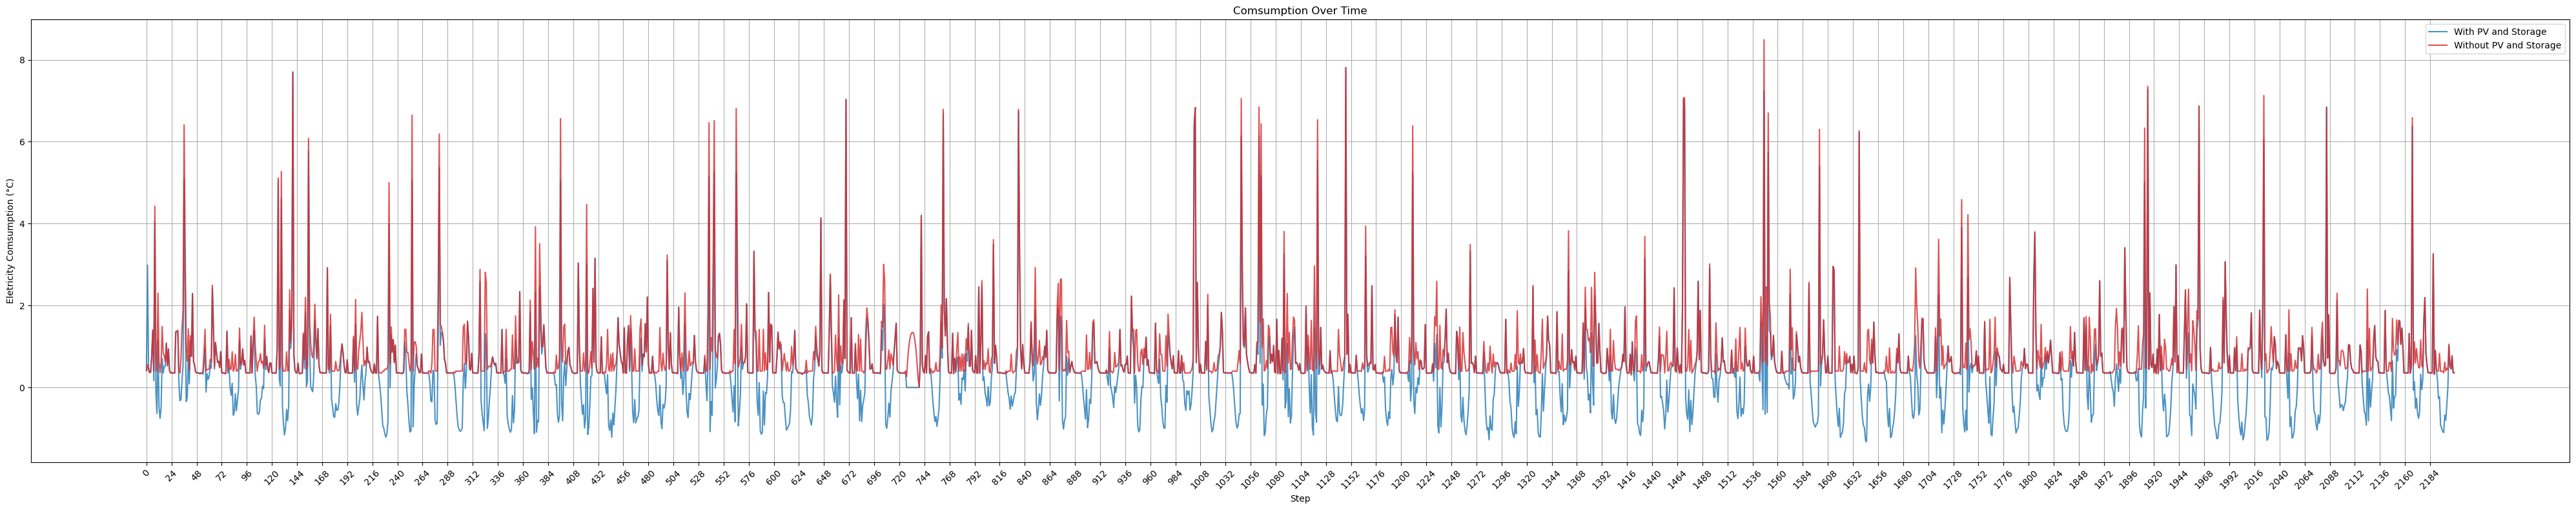

In [15]:
from utils import plotting_functions as plt

num_building = 0

#Calcola il consumo di elettricità totale dell'edificio
energy_with_pv= eval_env.buildings[num_building].net_electricity_consumption
energy_without_pv = eval_env.buildings[num_building].net_electricity_consumption_without_storage_and_pv

plt.plot_comparison_two(
    energy_with_pv,
    energy_without_pv,
    ylabel='Eletricity Comsumption (°C)',
    title='Comsumption Over Time',
    label1='With PV and Storage',
    label2='Without PV and Storage'
)

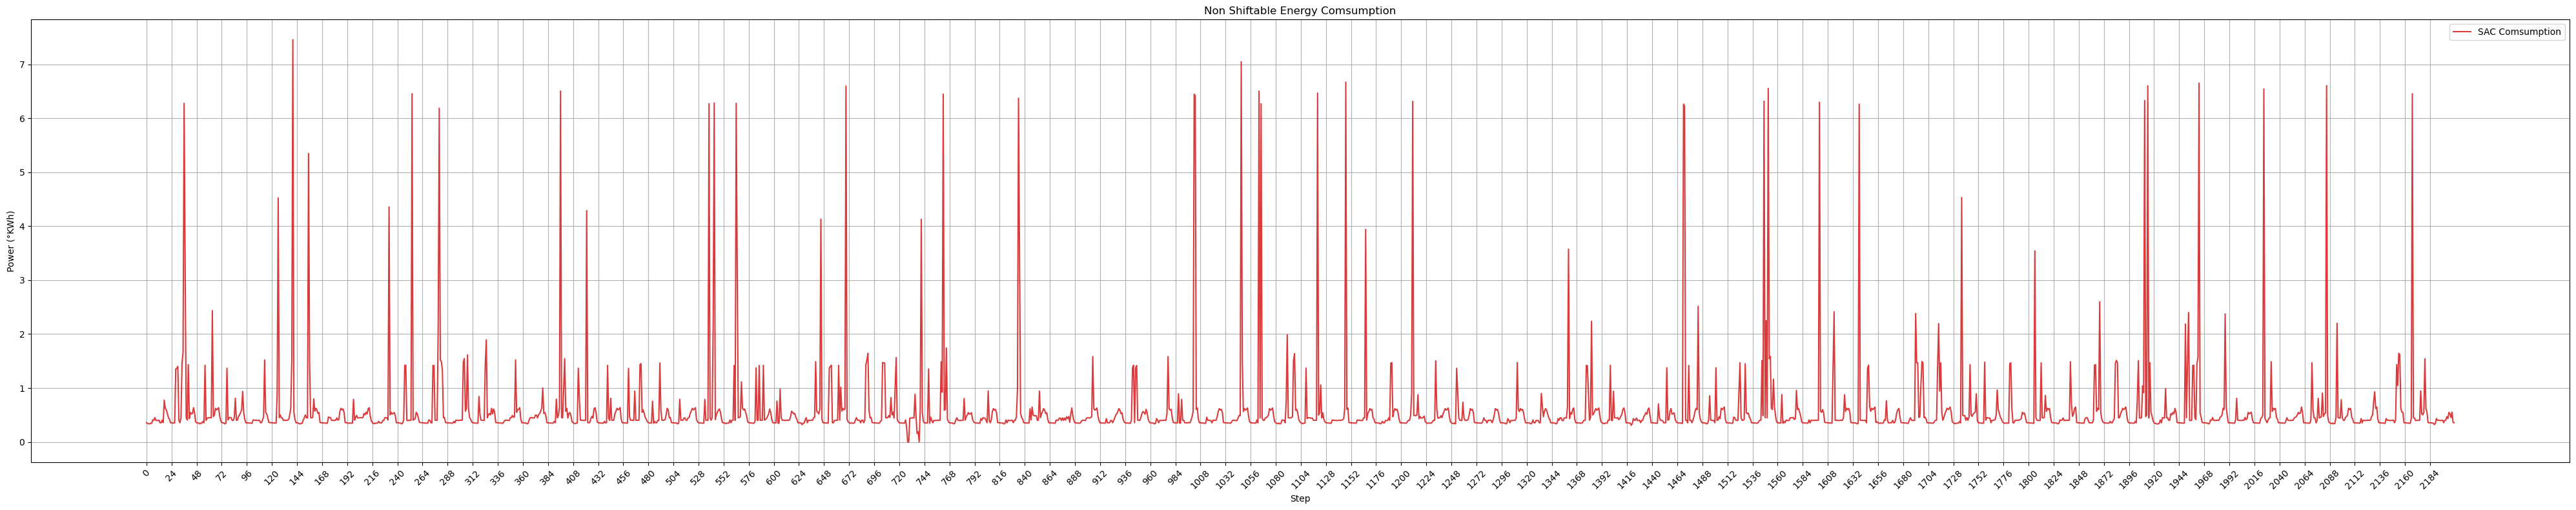

In [16]:

non_energy_sac = eval_env.buildings[num_building].non_shiftable_load_electricity_consumption

plt.plot_single_agent(
    non_energy_sac,
    ylabel='Power (°KWh)',
    title='Non Shiftable Energy Comsumption',
    label='SAC Comsumption',

)

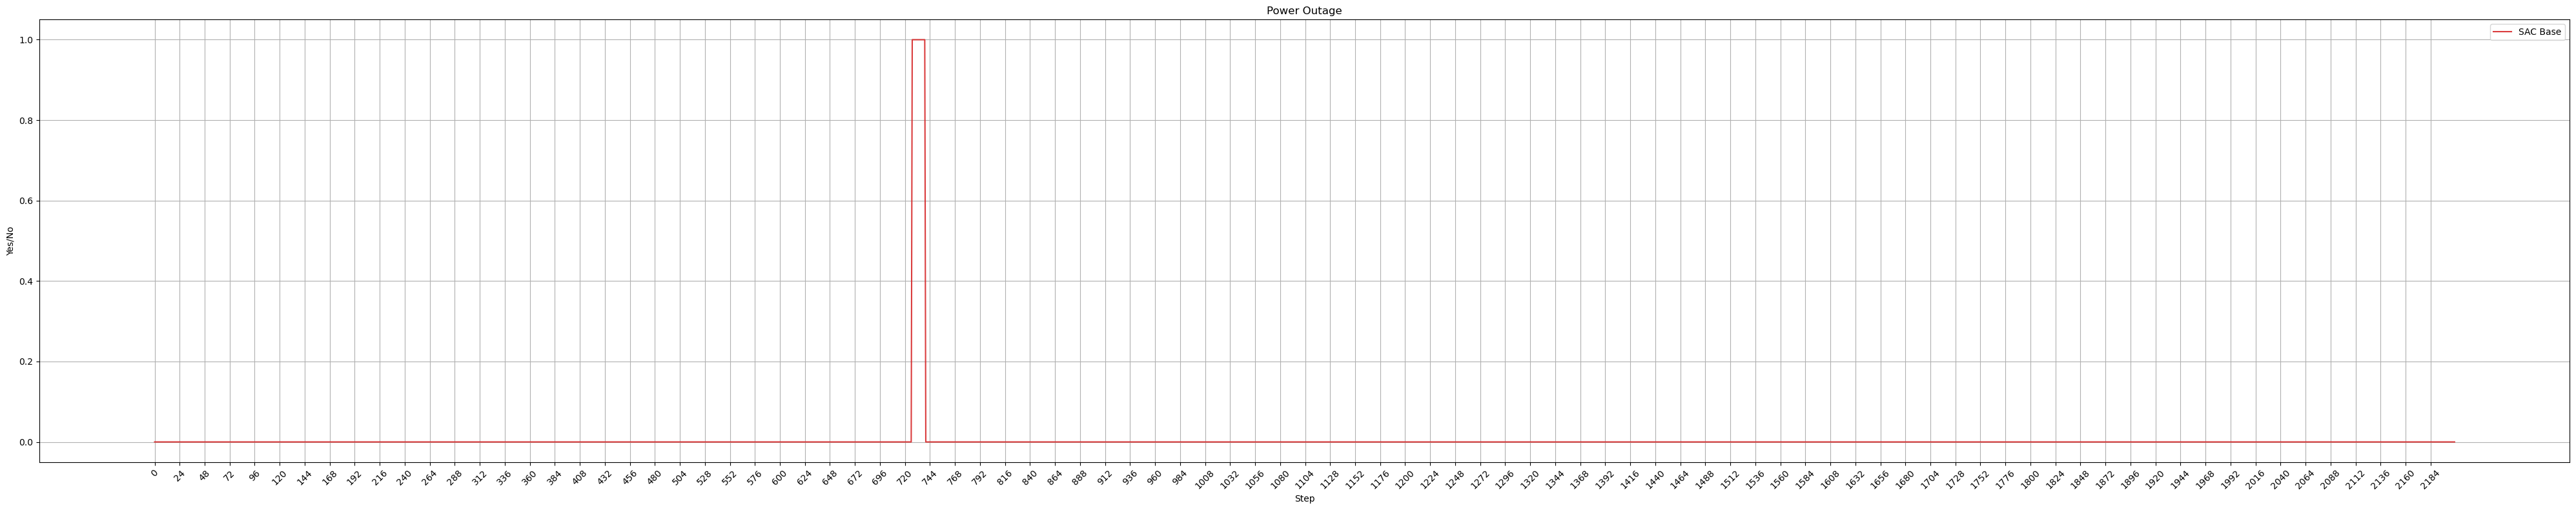

In [17]:
#ritorna i cali di corrente
energy= eval_env.buildings[num_building].power_outage_signal

plt.plot_single_agent(
    energy,
    ylabel='Yes/No',
    title='Power Outage',
    label='SAC Base',
)


------

## **Comportamento delle temperature**

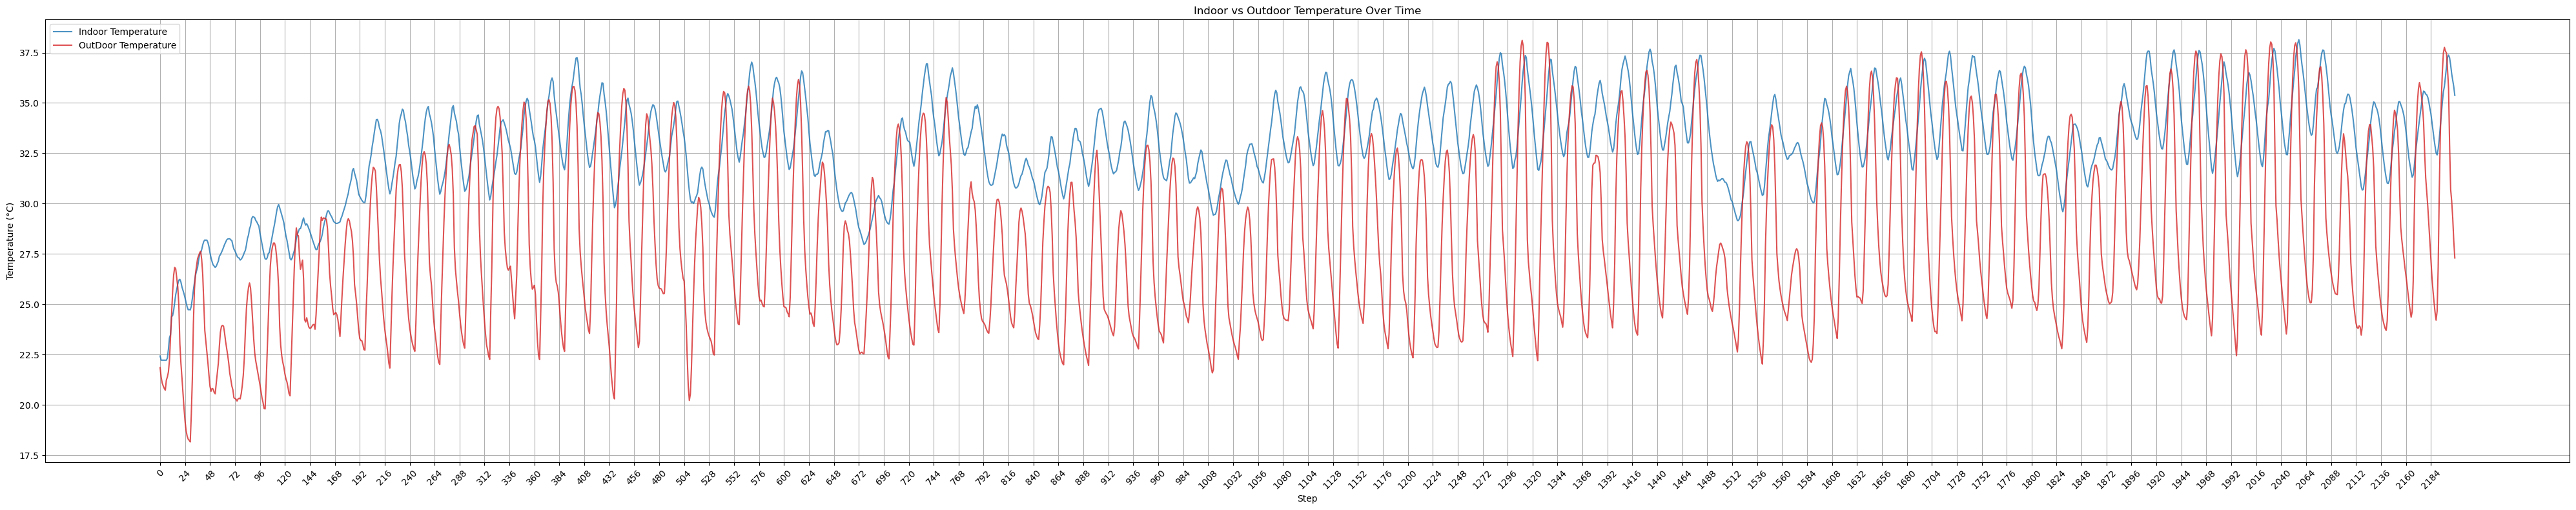

In [31]:
indoor_base_temp = eval_env.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = eval_env.buildings[num_building].weather.outdoor_dry_bulb_temperature


plt.plot_comparison_two(
    indoor_base_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    label1='Indoor Temperature',
    label2='OutDoor Temperature'
)


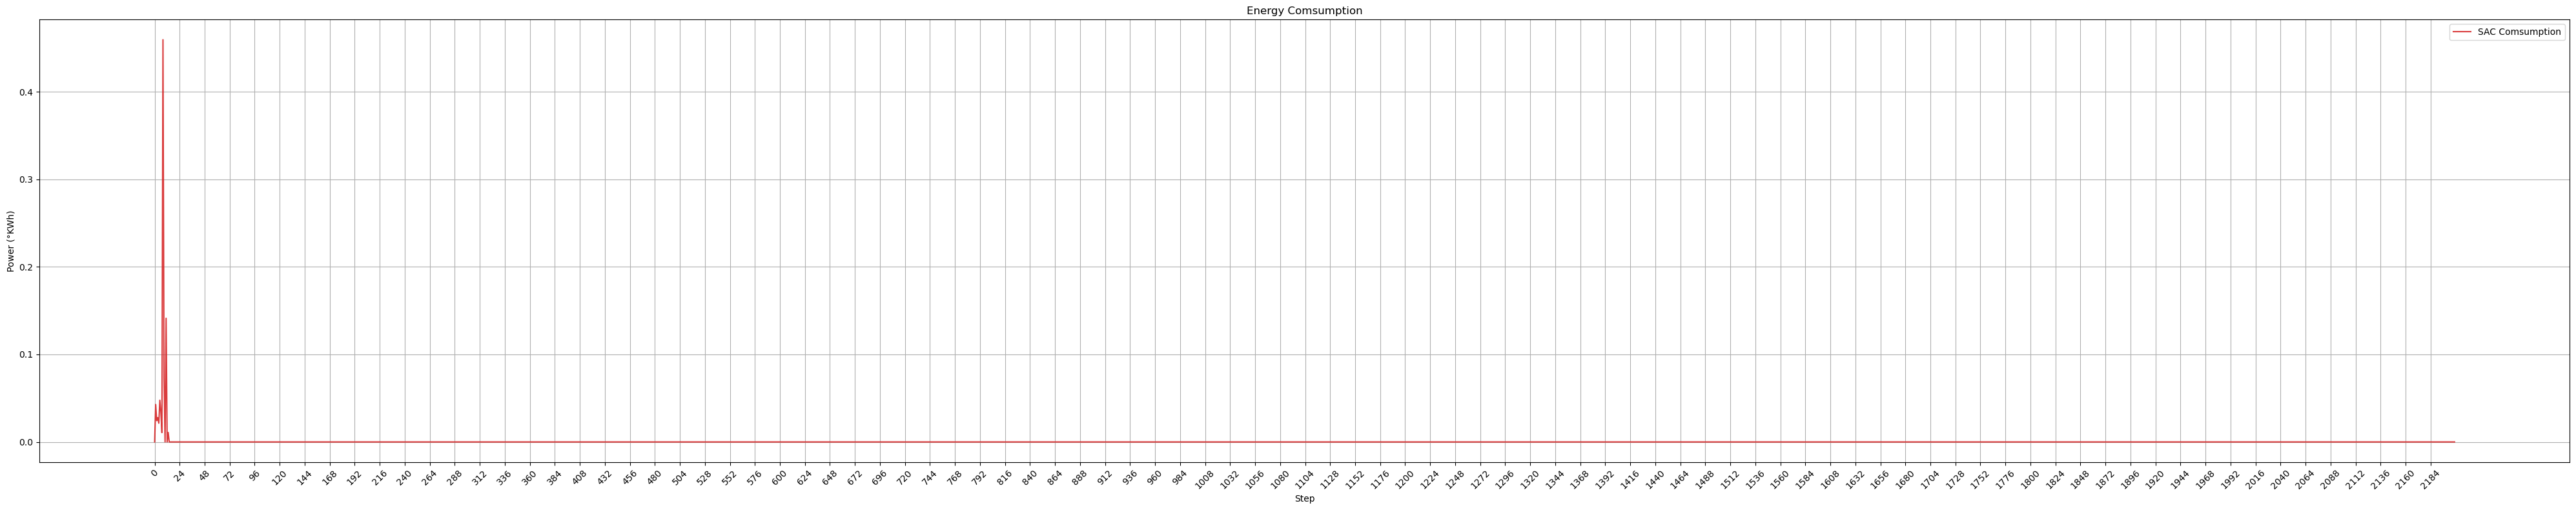

In [30]:
#Questa componente estrae la potenza utilizzata dei dispositivi che servono per regolare la temperatura ambientale

cooler_energy_sac = eval_env.buildings[num_building].cooling_electricity_consumption

plt.plot_single_agent(
    cooler_energy_sac,
    ylabel='Power (°KWh)',
    title='Energy Comsumption',
    label='SAC Comsumption',

)


----

## **Comportamento nell'utilizzo delle batterie**

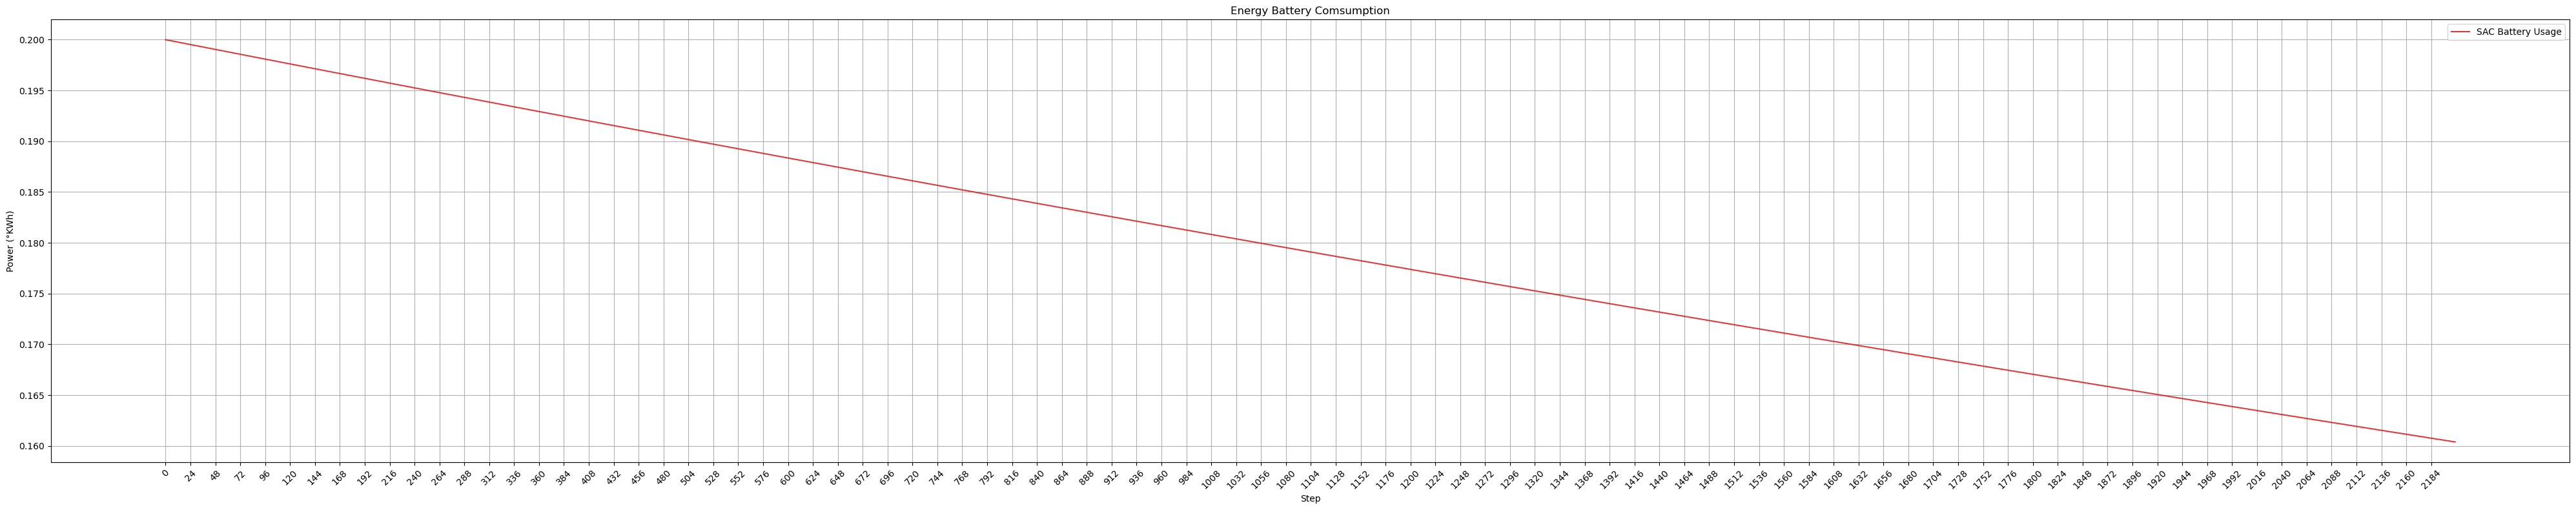

In [28]:
agent_data1 = eval_env.buildings[num_building].electrical_storage.soc

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='SAC Battery Usage'
)

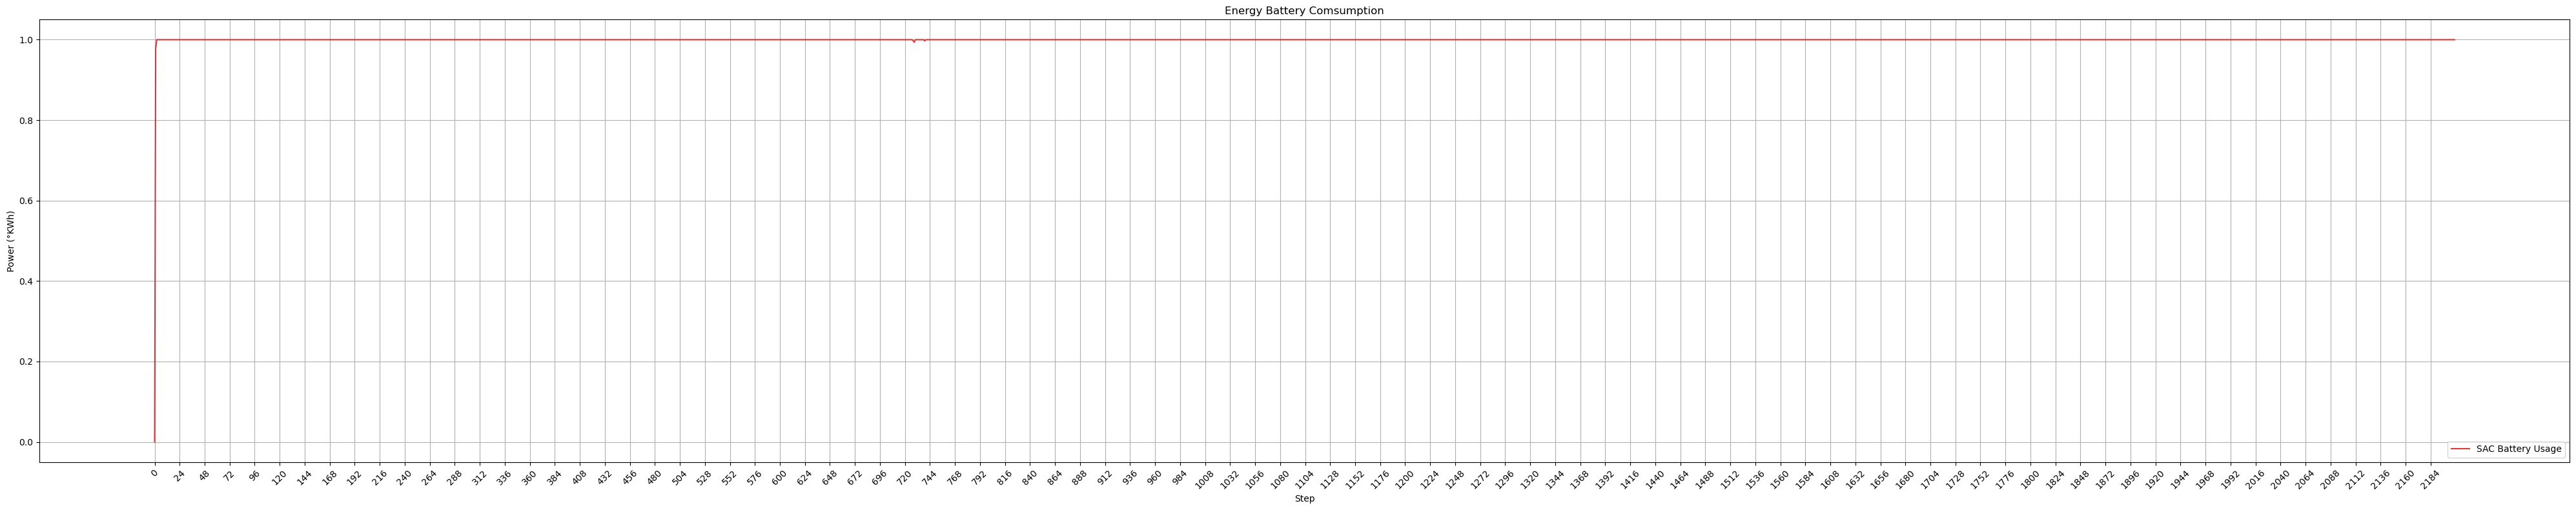

In [21]:
agent_data1 = eval_env.buildings[num_building].dhw_storage.soc

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='SAC Battery Usage'
)


----

## **Comportamento delle emissioni**

L'emissioni sono strettamente legate ai consumi di energia della rete, perciò le caratteristiche precedenti si propagano anche qua.

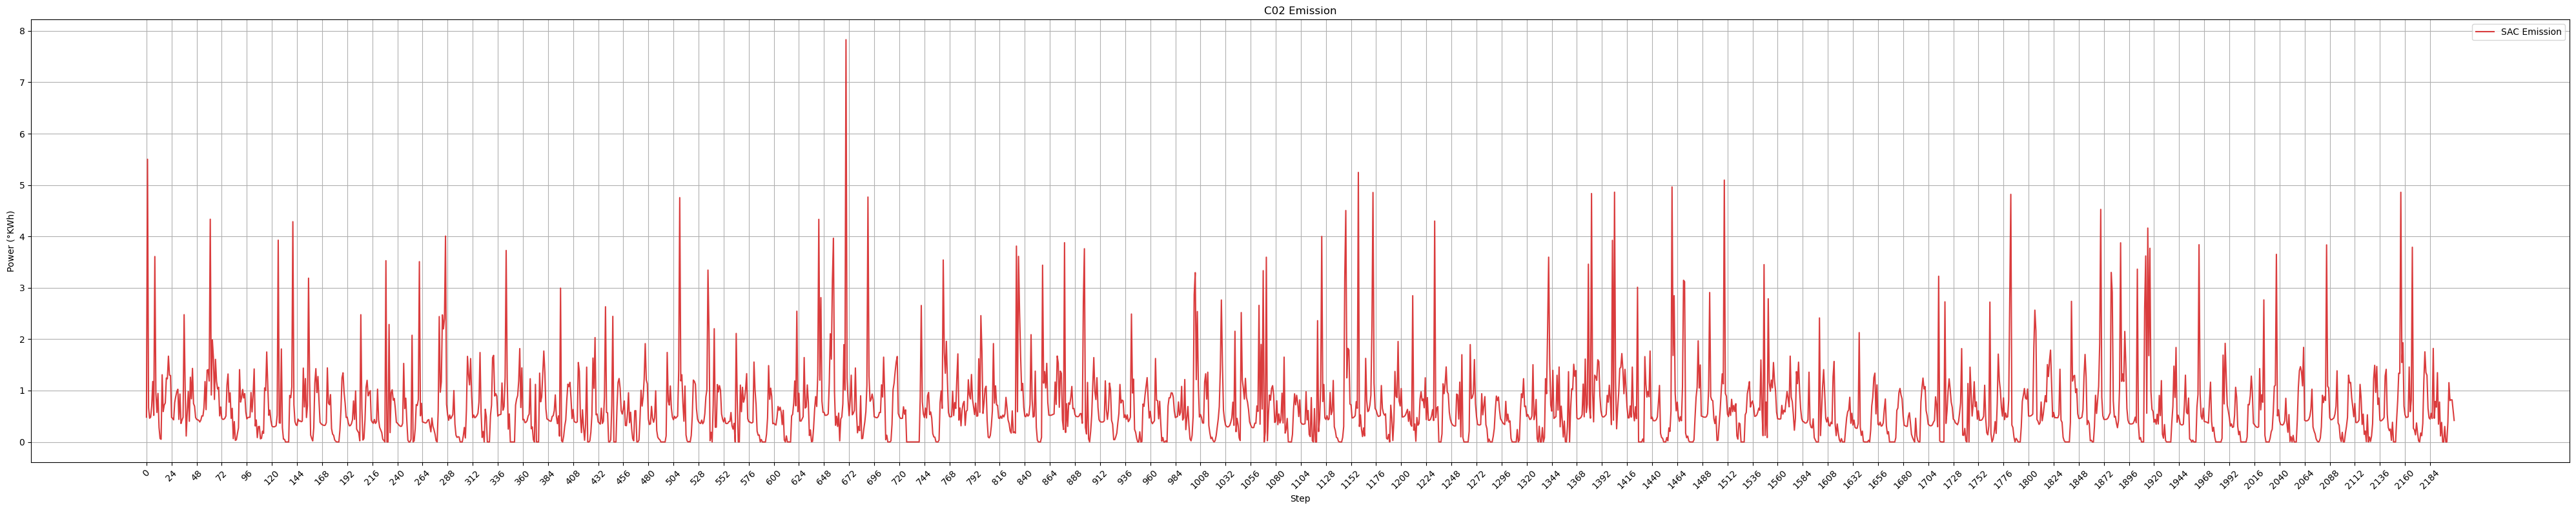

In [22]:
agent_data1 = eval_env.net_electricity_consumption_emission


plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='C02 Emission',
    label='SAC Emission'
)


----

## **Comportamento dei reward e dell'apprendimento**



,Episodio,Reward Min,Reward Max,Reward Somma,Reward Media
0,1,-497.073456,-1.152658,-715762.3750,-324.314636
1,2,-497.073456,-1.152658,-715762.3750,-324.314636
2,3,-497.073456,-1.152658,-715762.3750,-324.314636
3,4,-666.891113,-1.049510,-597260.3125,-270.620880


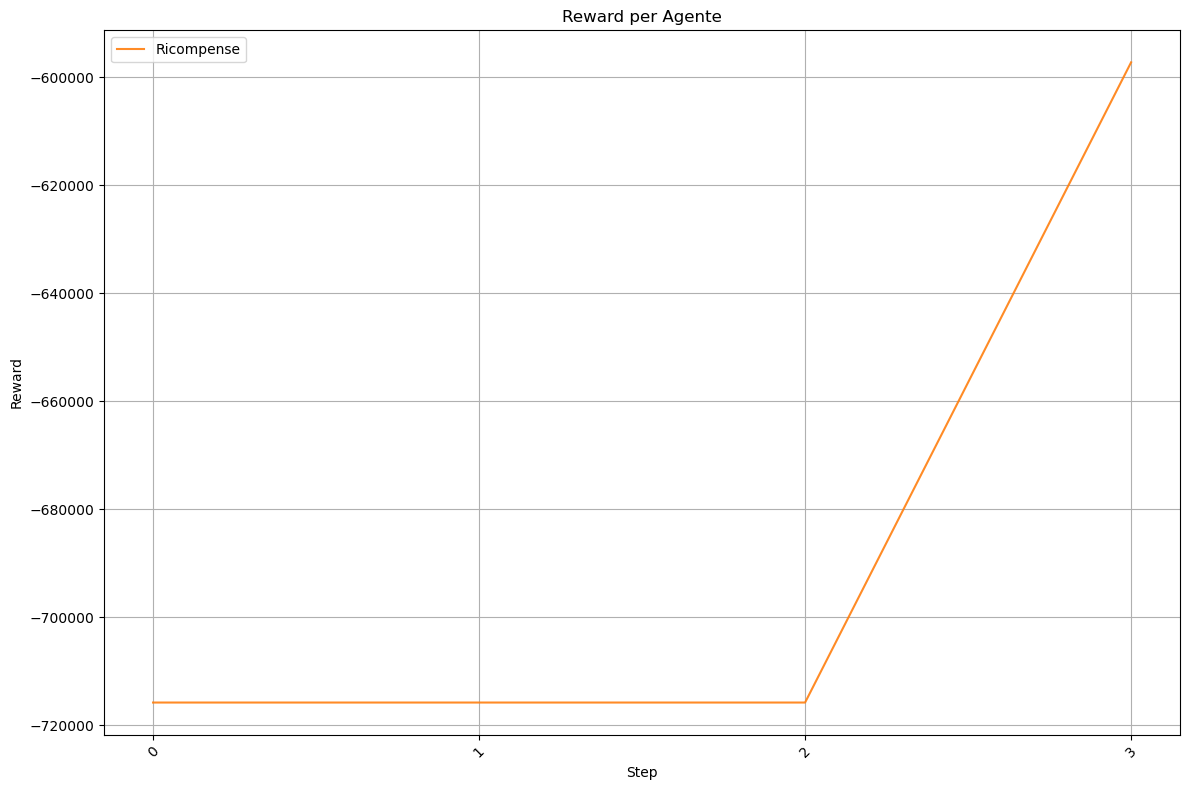

In [26]:
df = plt.create_episode_table(eval_env.episode_rewards)


display(df)

plt.plot_rewards(df['Reward Somma'])


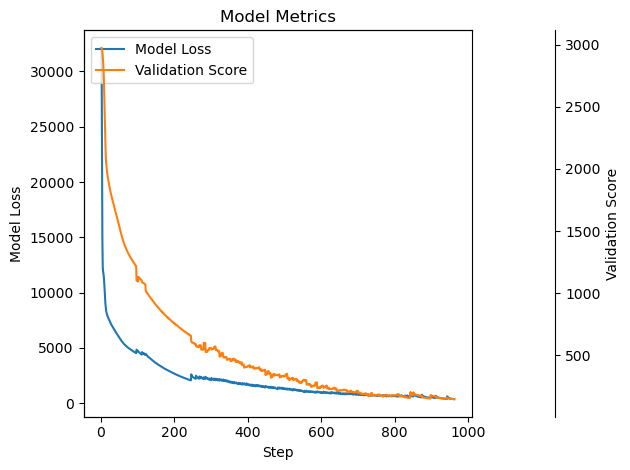

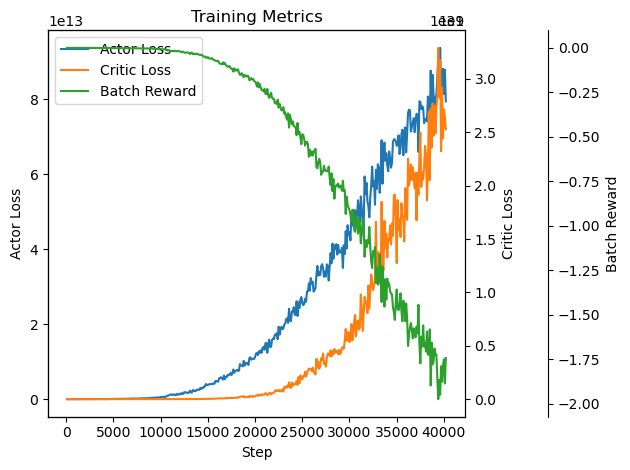

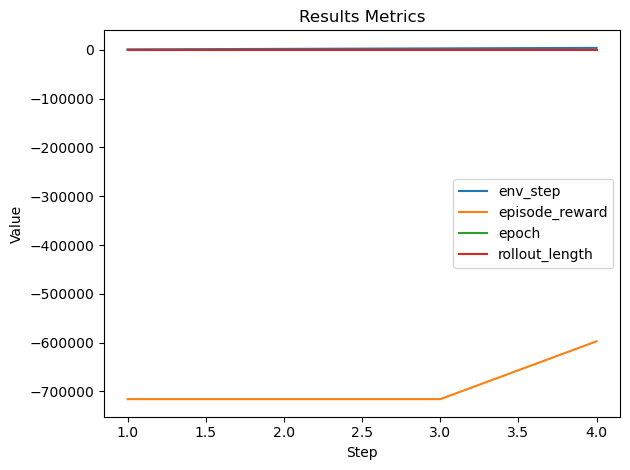

In [25]:
plt.plot_learning_metrics(os.getcwd()+"/exp/m2ac")